<a href="https://colab.research.google.com/github/Berigny/AI-Entrainment-Protocol/blob/main/LENR_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Energy Nuclear (LENR) Cycles Model (Fixed)
This notebook tests whether a minimal, topology-first model can simulate an
d falsify a low-energy nuclear reaction (LENR) cycle driven by breath-like EM co
herence.

## 1. Setup & Configuration

In [1]:
# @title 1.1 Config — Toggles & Seeds

# CONFIG
USE_STAR   = True          # S1 only if False; S1..S4 if True
USE_PADIC  = False
USE_QUAT   = True          # optional: quaternion state
RNG_SEED   = 13

import random
import numpy as np

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

In [2]:
# @title 1.2 Imports

import numpy as np
import networkx as nx
from mpmath import mpf, power
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.sparse import csr_matrix

%matplotlib inline

## 2. Geometry & Topology

In [3]:
# @title 2.1 Geometry — S1..S4 shells with role policy

ROLE_BY_MOD = {0: "Compression", 1: "Expression", 2: "Stabilisation", 3: "Emission"}

def build_geometry(use_star: bool = True):
    """Builds the STAR graph geometry before policy enforcement."""
    G = nx.DiGraph()
    nodes = ['C', 'S'] + [str(i) for i in range(16)]
    G.add_nodes_from(nodes)
    
    roles = {n: ('Mediator' if n == 'C' else 'Sink' if n == 'S' else ROLE_BY_MOD[int(n) % 4]) for n in G.nodes()}
    shells = {n: (f"S{1 + int(int(n) / 4)}" if n.isdigit() else '*') for n in G.nodes()}
    
    # Add intra-shell edges for all 4 shells
    for i in range(4):
        b = i * 4
        s = [str(b + j) for j in range(4)]
        G.add_edge('C', s[1], kind='activation')
        G.add_edge(s[1], s[2], kind='work')
        G.add_edge(s[2], 'C', kind='squeeze')
        G.add_edge('C', s[3], kind='fusion')
        G.add_edge(s[3], s[0], kind='heat')
        G.add_edge(s[0], 'C', kind='reset')

    # Add inter-shell (cubic) and sink edges
    for a, b in [(0, 4), (8, 12)]: G.add_edge(str(a), str(b), kind='compression'); G.add_edge(str(b), str(a), kind='compression')
    for a, b in [(3, 6), (11, 14)]: G.add_edge(str(a), str(b), kind='work_bridge')
    for e_node in [3, 7, 11, 15]: G.add_edge(str(e_node), 'C', kind='heat_bridge')
    for e_node in [3, 7, 11, 15]: G.add_edge(str(e_node), 'S', kind='sink')
    
    # Define the connection policy
    policy = {
        'Compression': {'out': {'Mediator', 'Compression'}, 'in': {'Emission', 'Compression', 'Mediator'}},
        'Expression': {'out': {'Stabilisation', 'Mediator'}, 'in': {'Mediator'}},
        'Stabilisation': {'out': {'Mediator'}, 'in': {'Expression', 'Emission'}},
        'Emission': {'out': {'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'Stabilisation', 'Mediator'}},
        'Mediator': {'out': {'Expression', 'Emission', 'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'*'}},
        'Sink': {'in': {'*'}} 
    }
    return G, roles, shells, policy

def enforce_policy(G, roles, policy):
    """Filters the graph, keeping only edges that conform to the policy."""
    keep = []
    for u, v, data in G.edges(data=True):
        ru, rv = roles.get(u, 'Mediator'), roles.get(v, 'Mediator')
        allowed_out = policy.get(ru, {}).get('out', set())
        allowed_in = policy.get(rv, {}).get('in', set())
        if ('*' in allowed_in or ru in allowed_in) and (rv in allowed_out):
            keep.append((u, v, data))
    
    H = nx.DiGraph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from(keep)
    return H

# Build and enforce
G_raw, roles, shells, policy = build_geometry(USE_STAR)
G0 = enforce_policy(G_raw, roles, policy)
nx.set_node_attributes(G0, roles, 'role')
nx.set_node_attributes(G0, shells, 'shell')
G0.graph.update({'roles': roles, 'shells': shells, 'policy': policy})

print(f"Raw graph edges: {G_raw.number_of_edges()}")
print(f"Policy-enforced graph: |V|={G0.number_of_nodes()} |E|={G0.number_of_edges()}")

Raw graph edges: 38
Policy-enforced graph: |V|=18 |E|=38


In [4]:
# @title 2.2 DEC Backbone — ∂ Operators & Rectangular Hodge Stars

def build_dec_backbone(G):
    """Builds the DEC backbone to match the provided graph G."""
    # Sort nodes for consistent ordering, handling non-digit nodes
    V = sorted(list(G.nodes()), key=lambda x: (not x.isdigit(), int(x) if x.isdigit() else float('inf'), x))
    node_id = {v: i for i, v in enumerate(V)}
    
    # Generate faces for all shells from the graph's shell structure
    F_tuples = []
    shells = nx.get_node_attributes(G, 'shell')
    shell_nodes = defaultdict(list)
    for node, shell in shells.items():
        if shell.startswith('S'):
            shell_nodes[shell].append(node)
    
    for shell, nodes in shell_nodes.items():
        # Outer faces of the tetrahedron
        F_tuples.extend([(nodes[0],nodes[1],nodes[2]), (nodes[0],nodes[1],nodes[3]), (nodes[0],nodes[2],nodes[3]), (nodes[1],nodes[2],nodes[3])])
        # Centroid-facing faces
        if 'C' in V:
            F_tuples.extend([(nodes[0],nodes[1],'C'), (nodes[0],nodes[2],'C'), (nodes[0],nodes[3],'C'), (nodes[1],nodes[2],'C'), (nodes[1],nodes[3],'C'), (nodes[2],nodes[3],'C')])
    F = [tuple(sorted(f)) for f in F_tuples]
    
    # Edges are derived from the faces to form the simplicial complex
    edges_backbone = sorted({tuple(sorted((a, b))) for a, b, c in F for a,b in [(a, b), (b, c), (c, a)]})
    edge_id = {e: i for i, e in enumerate(edges_backbone)}
    face_id = {f: i for i, f in enumerate(F)}
    n_edges = len(edges_backbone)
    n_faces = len(F)
    
    # Boundary Maps
    B1 = np.zeros((len(V), n_edges), dtype=float)
    for (u,v), ei in edge_id.items():
        if u in node_id and v in node_id:
            B1[node_id[u], ei] = -1.0
            B1[node_id[v], ei] = 1.0
    B1 = csr_matrix(B1)
    
    B2 = np.zeros((n_edges, n_faces), dtype=float)
    for fj, (v0, v1, v2) in enumerate(F_tuples):
        face_edges = [(v0,v1), (v1,v2), (v2,v0)]
        for u,v in face_edges:
            e_sorted = tuple(sorted((u,v)))
            if e_sorted in edge_id:
                sign = 1 if (u,v) == e_sorted else -1
                B2[edge_id[e_sorted], fj] = sign
    B2 = csr_matrix(B2)
    
    # Rectangular Hodge Stars (via incidence averaging)
    Inc_fe = np.zeros((n_faces, n_edges))
    for f_idx, face in enumerate(F):
        face_nodes = set(face)
        for e_idx, edge in enumerate(edges_backbone):
            if set(edge).issubset(face_nodes):
                Inc_fe[f_idx, e_idx] = 1.0
    
    face_deg = Inc_fe.sum(axis=1, keepdims=True)
    face_deg[face_deg == 0] = 1.0
    Inc_fe_avg = Inc_fe / face_deg
    Inc_ef_avg = Inc_fe_avg.T

    star_eps = csr_matrix(Inc_fe_avg)      # Edges -> Faces
    star_muinv = csr_matrix(Inc_ef_avg)    # Faces -> Edges

    # SPD Energy Forms
    Se = (star_eps.T @ star_eps)
    Sb = (star_muinv.T @ star_muinv)

    # Damping Matrix R
    damping_rates = {e: 0.1 if 'S' in e else 0.0 for e in edges_backbone}
    R = csr_matrix(np.diag([damping_rates.get(e, 0.0) for e in edges_backbone]))

    # Audits
    inf_norm = np.max(np.abs(B1 @ B2)) if (B1 @ B2).nnz > 0 else 0.0
    print(f"[DEC Dims] |V|={len(V)} |E|={n_edges} |F|={n_faces}")
    print(f"||B1·B2||_∞ = {inf_norm:.3e} (expect 0)")
    
    return V, F, node_id, edge_id, face_id, B1, B2, star_eps, star_muinv, Se, Sb, R

V, F, node_id, edge_id, face_id, B1, B2, star_eps, star_muinv, Se, Sb, R = build_dec_backbone(G0)

[DEC Dims] |V|=18 |E|=40 |F|=40
||B1·B2||_∞ = 0.000e+00 (expect 0)


In [5]:
# @title 2.3 Energy Forms & Power Pairings

# Map J (faces) to edges for power pairing with E
J_faces_to_edges = star_muinv # This is equivalent to Inc_ef_avg

def edge_damping_power(E_vec):
    return float(E_vec @ (R @ E_vec))

def stored_energy(E_vec, B_vec):
    return 0.5 * (E_vec @ (Se @ E_vec) + B_vec @ (Sb @ B_vec))

## 3. Markov Layer & Simulation Engine

In [6]:
# @title 3.1 Markov Layer & Breath Modulation

def build_markov(G):
    """Adds 'rate' and 'kind' attributes to graph edges based on a base dictionary."""
    base = {
        'activation': 0.5, 'work': 0.8, 'squeeze': 0.9, 'fusion': 0.7,
        'heat': 1.0, 'reset': 0.3, 'compression': 0.3,
        'work_bridge': 0.4, 'heat_bridge': 0.5, 'sink': 0.2
    }
    rates = {e: base.get(d.get('kind', 'work'), 0.5) for e, d in G.edges.items()}
    kinds = {e: d.get('kind', 'work') for e, d in G.edges.items()}
    nx.set_edge_attributes(G, rates, 'rate')
    nx.set_edge_attributes(G, kinds, 'kind')
    return rates, kinds

EDGE_RATES, EDGE_KINDS = build_markov(G0)

def apply_breath(G_base, step, inhale_gain=1.15, exhale_gain=1.10):
    """Applies breath-like modulation to edge rates."""
    phase = 'in' if (step % 2) == 0 else 'out'
    G = G_base.copy()
    roles = G.graph['roles']
    sinks = {n for n, r in roles.items() if r == 'Compression'}
    sources = {'C'}
    pumps = {n for n, r in roles.items() if r in {'Expression', 'Emission'}}
    for u, v, data in G.edges(data=True):
        rate = data['rate'] # Start with the base rate
        if phase == 'in' and (v in sinks or v in sources): rate *= inhale_gain
        elif phase == 'out' and (u in sources and v in pumps): rate *= exhale_gain
        data['rate'] = rate # Update the rate for the current step
    return G, phase

print(f"Markov layer: {len(EDGE_RATES)} edges across kinds {sorted(set(EDGE_KINDS.values()))}")

Markov layer: 38 edges across kinds ['activation', 'compression', 'fusion', 'heat', 'heat_bridge', 'reset', 'sink', 'squeeze', 'work', 'work_bridge']


In [7]:
# @title 3.2 Quaternion State & Coupling (Optional)

def init_quaternion_state(G, roles):
    Q = {n: np.zeros(4) for n in G.nodes()}
    for n, r in roles.items():
        if r == 'Compression': Q[n] = np.array([1.0, 0.0, 0.2, 0.0])
        elif r == 'Expression': Q[n] = np.array([0.1, 1.0, 0.0, 0.0])
        elif r == 'Stabilisation': Q[n] = np.array([0.0, 0.0, 1.0, 0.1])
        elif r == 'Emission': Q[n] = np.array([0.0, 0.1, 0.0, 1.0])
    return Q

def project(flow_kind, vec):
    arr = np.asarray(vec, dtype=float)
    if flow_kind in ('work', 'activation'): return float(arr[1])
    if flow_kind in ('squeeze', 'reset'): return float(arr[0] + arr[2])
    if flow_kind in ('fusion', 'work_bridge'): return float(arr[3] + arr[1])
    if flow_kind in ('heat', 'heat_bridge'): return float(arr[3])
    if flow_kind == 'compression': return float(arr[0])
    if flow_kind == 'sink': return float(arr.sum())
    return 0.0

QUAT_STATE = init_quaternion_state(G0, roles) if USE_QUAT else {}

def _edge_sign_index(u, v, edge_id):
    e_sorted = tuple(sorted((u,v)))
    if e_sorted in edge_id:
        sign = 1.0 if (u,v) == e_sorted else -1.0
        return sign, edge_id[e_sorted]
    return 0.0, None

def markov_to_currents(Gk, edge_id, coherence_gain=0.1, state=None):
    J = np.zeros(len(edge_id), dtype=float)
    active_kinds = set(EDGE_KINDS.values()) - {'heat', 'heat_bridge', 'sink'}
    state = QUAT_STATE if state is None and USE_QUAT else state
    for u, v, data in Gk.edges(data=True):
        kind, rate = data.get('kind'), data.get('rate', 0.0)
        if kind not in active_kinds or rate <= 0.0: continue
        sgn, ei = _edge_sign_index(u, v, edge_id)
        if ei is None: continue
        amp = project(kind, state.get(u, np.zeros(4))) if state else 1.0
        J[ei] += sgn * coherence_gain * rate * amp
    return J

def accumulate_heat(Gk, dt, state):
    """Heat export coupled to live quaternion state."""
    total = 0.0
    heat_kinds = {'heat', 'heat_bridge', 'sink'}
    for u, v, d in Gk.edges(data=True):
        if d.get('kind') not in heat_kinds: continue
        rate = float(d.get('rate', 0.0))
        vec  = state.get(u, np.zeros(4))
        # Using k-component (inductive/emission) for heat coupling
        kamp = float(vec[3])
        total += rate * kamp
    return total * dt

if USE_QUAT: print("Quaternion state initialised.")

Quaternion state initialised.


In [8]:
# @title 3.3 Phase Linter

def build_phase_linter(G, S1_nodes, S2_nodes):
    """Builds and returns the linter function."""
    node_list = sorted(list(G.nodes()), key=lambda x: (not x.isdigit(), int(x) if x.isdigit() else x))
    idx = {k: i for i, k in enumerate(node_list)}
    n_nodes = len(node_list)
    kap = np.zeros((n_nodes, n_nodes))
    theta = np.zeros_like(kap)

    def _set_k(a, b, val): 
        if a in idx and b in idx: i, j = idx[a], idx[b]; kap[i,j]=val; kap[j,i]=val
    def _set_th(a, b, rad): 
        if a in idx and b in idx: i, j = idx[a], idx[b]; theta[i,j]=rad; theta[j,i]=-rad

    # Define couplings
    for U in (S1_nodes, S2_nodes):
        for i, u in enumerate(U): 
            for v in U[i+1:]: _set_k(u, v, 0.02)
    _set_k('1', '2', 0.12); _set_th('1', '2', np.pi/2)
    if USE_STAR:
        _set_k('5', '6', 0.12); _set_th('5', '6', np.pi/2)
        _set_k('3', '6', 0.08); _set_th('3', '6', np.pi/2)
        for p in [('7','4'), ('7','2'), ('5','0')]: _set_k(*p, 0.05); _set_th(*p, np.pi)

    gamma_C = 0.05
    phi_state = np.zeros(n_nodes)

    def linter_fn(step, dt=0.05, relax_steps=5):
        nonlocal phi_state
        for _ in range(relax_steps):
            d_phi = np.zeros_like(phi_state)
            for i, u in enumerate(node_list):
                if u == 'C': continue
                acc = sum(kap[i,j] * np.sin(phi_state[j] - phi_state[i] - theta[i,j]) for j in range(n_nodes) if i != j)
                if 'C' in idx: acc -= gamma_C * np.sin(phi_state[i] - phi_state[idx['C']])
                d_phi[i] = acc
            phi_state += dt * d_phi
            phi_state = (phi_state + np.pi) % (2 * np.pi) - np.pi
        
        errors = []
        def err(a,b,trg): 
            if a in idx and b in idx: return np.degrees(np.abs(_wrap_pi((phi_state[idx[a]]-phi_state[idx[b]])-trg)))
            return np.nan
        errors.append(err('1','2',np.pi/2))
        if USE_STAR: errors.extend([err('5','6',np.pi/2), err('3','6',np.pi/2)])
        return np.nanmean([e for e in errors if np.isfinite(e)])

    def _wrap_pi(x): return (x + np.pi) % (2 * np.pi) - np.pi
    return linter_fn

linter_fn = build_phase_linter(G0, [str(i) for i in range(4)], [str(i) for i in range(4,8)])
print("Phase linter function 'linter_fn' created.")

Phase linter function 'linter_fn' created.


In [9]:
# @title 3.4 Core Engine — Leapfrog DEC Loop

def run_lenr_core(
    G_base, steps: int = 400, dt: float = 1e-3, coherence_gain: float = 0.1, 
    report_every: int = 20, state: dict = None):
    """Runs the main DEC simulation loop."""
    
    n_edges = B1.shape[1]
    n_faces = B2.shape[1]
    
    E = np.zeros(n_edges, dtype=float)
    B = np.zeros(n_faces, dtype=float)
    
    # Initial condition: small pump on C->1 if it exists on the backbone
    s, C1_idx = _edge_sign_index('C', '1', edge_id)
    if C1_idx is not None: E[C1_idx] = 1e-4 * s
    
    U = stored_energy(E, B)
    Q = 0.0
    
    hist = {k: [] for k in ["heat", "energy", "residual", "phase_error", "samples", "Rc_in", "Rc_out", "sink_throughput"]}
    hist['dt'] = dt
    
    def _centroid_reliance_local(Gk):
        total = sum(d.get('rate', 0.0) for u,v,d in Gk.edges(data=True))
        via_c = sum(d.get('rate', 0.0) for u,v,d in Gk.edges(data=True) if u == 'C' or v == 'C')
        return via_c / total if total > 0.0 else 0.0
    
    for n in range(steps):
        Gk, phase = apply_breath(G_base, n)
        J_work = markov_to_currents(Gk, edge_id, coherence_gain, state)
        
        # Faraday: dB/dt = - curl E
        B -= dt * (B2.T @ E)

        # Ampere: dE/dt = curl(H) - J_cond
        H = star_muinv @ B
        dE = (B2 @ H) - J_work
        E += dt * dE - dt * (R @ E)
        
        # Accounting & Diagnostics
        dQ = accumulate_heat(Gk, dt, QUAT_STATE) + edge_damping_power(E) * dt
        Q_new = Q + dQ

        U_new = stored_energy(E, B)
        dU = U_new - U
        # The injected work is implicitly handled by the J_work term in Ampere's law.
        # The residual checks if the change in stored energy is balanced by dissipated heat.
        residual = dU + dQ
        
        if n % report_every == 0 or n == steps - 1:
            hist["heat"].append(Q_new)
            hist["energy"].append(U_new)
            hist["residual"].append(residual)
            hist["samples"].append(n)
            hist["phase_error"].append(linter_fn(n))
            hist["sink_throughput"].append(dQ / dt)
            rc = _centroid_reliance_local(Gk)
            hist[f"Rc_{phase}"].append(rc)
            
        U, Q = U_new, Q_new
            
    return hist

print("Core engine 'run_lenr_core' defined.")

Core engine 'run_lenr_core' defined.


## 4. Thermodynamic Diagnostics

In [10]:
# @title 4.1 Markov Thermodynamics — Zeroth/Second/Third-Law Analogues

def get_stationary_distribution(P):
    """Computes the stationary distribution of a Markov transition matrix P."""
    eigenvalues, eigenvectors = np.linalg.eig(P.T)
    # Find the eigenvector corresponding to the eigenvalue 1
    idx = np.argmin(np.abs(eigenvalues - 1))
    pi = np.real(eigenvectors[:, idx])
    # Normalize the stationary distribution
    return pi / pi.sum()

def compute_epr(Pm, stationary):
    """Computes the entropy production rate (EPR) for a Markov process."""
    epr = 0.0
    n_nodes = Pm.shape[0]
    for i in range(n_nodes):
        for j in range(n_nodes):
            if Pm[i, j] > 0 and stationary[i] > 0:
                # Add a small epsilon to prevent log(0)
                flux = stationary[i] * Pm[i, j]
                ratio = Pm[i, j] / (Pm[j, i] + 1e-12)
                if ratio > 0:
                    epr += flux * np.log(ratio)
    return epr

# --- Normal Scenario ---
n_nodes = len(V)
P_normal = np.zeros((n_nodes, n_nodes))
for u, v, data in G0.edges(data=True):
    if u in node_id and v in node_id:
        P_normal[node_id[u], node_id[v]] = data['rate']
row_sums = P_normal.sum(axis=1, keepdims=True)
P_normal = np.divide(P_normal, row_sums, where=row_sums!=0)
pi_normal = get_stationary_distribution(P_normal)
epr_normal = compute_epr(P_normal, pi_normal)

# --- Counterfactual Scenario (2->1 like shortcut) ---
# Find a policy-violating edge to add. E.g., Expression -> Expression is not allowed.
# Let's add an edge from node '1' to '5' (both Expression).
G_counter = G0.copy()
G_counter.add_edge('1', '5', rate=0.5) # Arbitrary rate for the forbidden edge
P_counter = np.zeros((n_nodes, n_nodes))
for u, v, data in G_counter.edges(data=True):
    if u in node_id and v in node_id:
        P_counter[node_id[u], node_id[v]] = data['rate']
row_sums_c = P_counter.sum(axis=1, keepdims=True)
P_counter = np.divide(P_counter, row_sums_c, where=row_sums_c!=0)
pi_counter = get_stationary_distribution(P_counter)
epr_counter = compute_epr(P_counter, pi_counter)

# --- Low-Theta Scenario ---
theta = 0.1
P_low_T = np.zeros((n_nodes, n_nodes))
for u, v, data in G0.edges(data=True):
    rate = data['rate']
    if u in ['C', 'S'] or v in ['C', 'S']:
        rate *= theta
    if u in node_id and v in node_id:
        P_low_T[node_id[u], node_id[v]] = rate
row_sums_lt = P_low_T.sum(axis=1, keepdims=True)
P_low_T = np.divide(P_low_T, row_sums_lt, where=row_sums_lt!=0)
pi_low_T = get_stationary_distribution(P_low_T)
epr_low_T = compute_epr(P_low_T, pi_low_T)

print(f"EPR (Normal): {epr_normal:.4f}")
print(f"EPR (Counterfactual): {epr_counter:.4f}")
print(f"EPR (Low-Theta): {epr_low_T:.4f}")

EPR (Normal): 17.3566
EPR (Counterfactual): 30.7538
EPR (Low-Theta): 8.2252


## 5. Simulation & Analysis

In [11]:
# @title 5.1 Run Simulation

hist = run_lenr_core(
    G0, 
    steps=1000, 
    dt=1e-4, 
    coherence_gain=0.25, 
    report_every=10, 
    state=QUAT_STATE
)

print("Simulation complete. History contains keys:", list(hist.keys()))

Simulation complete. History contains keys: ['heat', 'energy', 'residual', 'phase_error', 'samples', 'Rc_in', 'Rc_out', 'sink_throughput', 'dt']


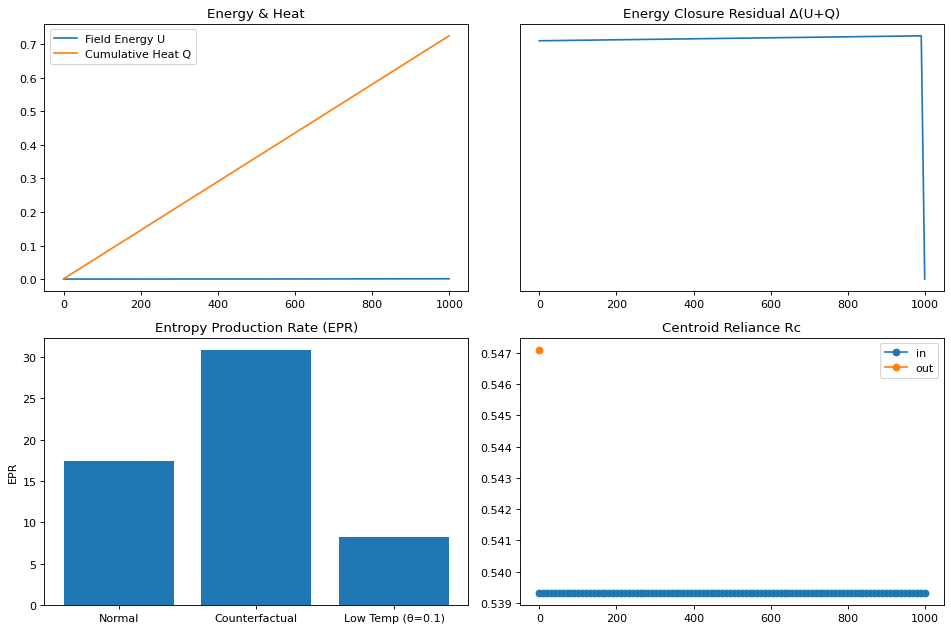

In [12]:
# @title 5.2 Visualizations

def plot_diagnostics(hist, epr_normal, epr_counter, epr_low_T, theta):
    s = hist.get("samples", [])
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=80)
    
    # Energy & Heat
    axs[0,0].plot(s, hist.get("energy", []), label="Field Energy U")
    axs[0,0].plot(s, hist.get("heat", []), label="Cumulative Heat Q")
    axs[0,0].set_title("Energy & Heat")
    axs[0,0].legend()
    
    # Residual
    axs[0,1].plot(s, hist.get("residual", []))
    axs[0,1].set_title("Energy Closure Residual Δ(U+Q)")
    axs[0,1].set_yscale('symlog', linthresh=1e-9)
    
    # EPR
    epr_labels = ['Normal', 'Counterfactual', f'Low Temp (θ={theta})']
    epr_values = [epr_normal, epr_counter, epr_low_T]
    axs[1,0].bar(epr_labels, epr_values)
    axs[1,0].set_title("Entropy Production Rate (EPR)")
    axs[1,0].set_ylabel("EPR")

    # Centroid Reliance
    rc_in_steps = np.linspace(s[0], s[-1], len(hist.get("Rc_in",[])))
    rc_out_steps = np.linspace(s[0], s[-1], len(hist.get("Rc_out",[])))
    axs[1,1].plot(rc_in_steps, hist.get("Rc_in",[]), 'o-', label='in')
    axs[1,1].plot(rc_out_steps, hist.get("Rc_out",[]), 'o-', label='out')
    axs[1,1].set_title("Centroid Reliance Rc")
    axs[1,1].legend()
    
    plt.tight_layout()
    plt.show()

plot_diagnostics(hist, epr_normal, epr_counter, epr_low_T, theta)